Install necessary libraries

In [14]:
%pip install torch torchvision torchsummary gdown pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Import necessary libraries

In [70]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import gdown
from torchvision.datasets import Caltech101

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime
import os

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc,precision_recall_curve,average_precision_score,PrecisionRecallDisplay

In [4]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Lambda(lambda img: img.convert("RGB")), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

caltech_dataset = Caltech101(root='./data', download=True, transform=data_transform)

train_size = int(len(caltech_dataset) * 0.8)
test_size = len(caltech_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(caltech_dataset, [train_size, test_size])

BATCH_SIZE = 16
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Files already downloaded and verified


Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

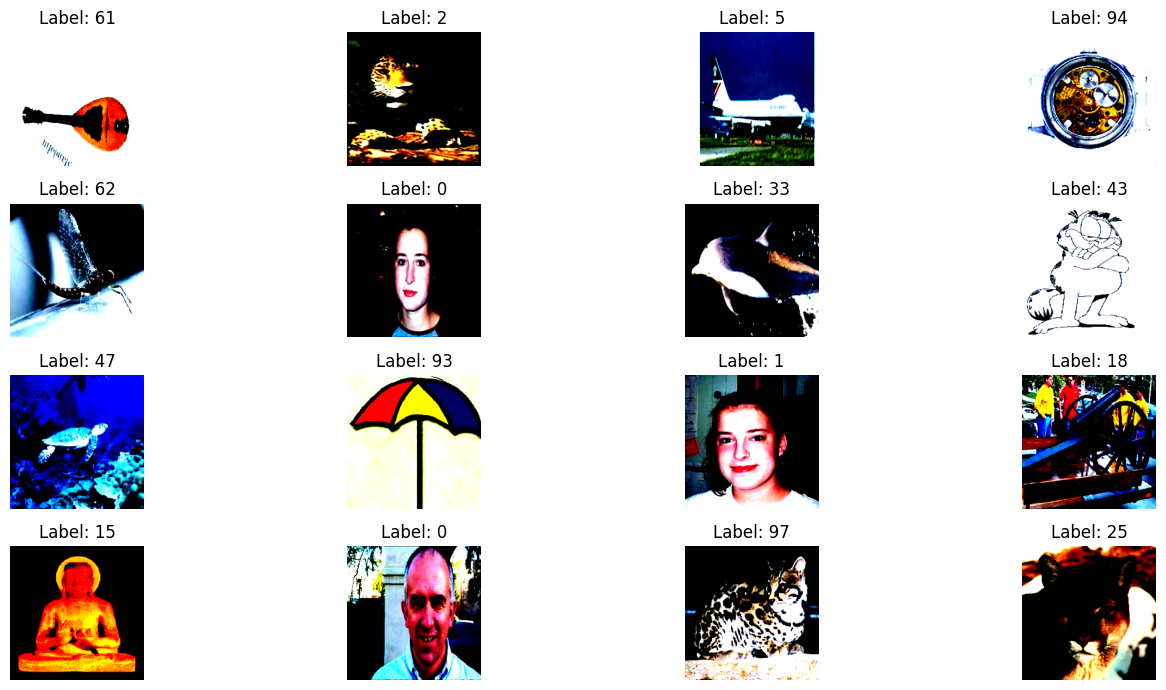

In [5]:
def show_grid(images, labels, ncols=4):
    nrows = len(images) // ncols + int(len(images) % ncols > 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))

    for idx, (image, label) in enumerate(zip(images, labels)):
        row, col = idx // ncols, idx % ncols
        axes[row, col].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Label: {label}')
    
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_data_loader))

show_grid(images, labels)

CNN

In [6]:
def tr_loop(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)  
    correct = 0 
    total_loss = 0  
    model.train()  
    for batch, (X, y) in enumerate(dataloader): 

        pred = model(X)  # 
        loss = loss_fn(pred, y)  

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        total_loss += float(loss.item())
        if batch % 100 == 0: 
            loss, current = float(loss.item()), (batch + 1) * len(X)
            print(f"Accuracy: {(100 * correct / current):>0.1f}%, Average loss: {loss:>7f},\t[{current:>5d}/{size:>5d}]")
    
    writer.add_scalar("Loss/train", total_loss/len(dataloader), epoch)  
    writer.add_scalar("Accuracy/train", 100 * correct / size, epoch) 

    print(f"Train Accuracy: {100 * correct / size:>0.1f}%, Average loss: {total_loss/len(dataloader):>7f} ")  # Вивести загальну точність та втрату


delete

In [7]:
def ts_loop(dataloader, model, loss_fn, epoch, writer):
    size = len(dataloader.dataset)  
    num_batches = len(dataloader)  
    model.eval()  
    test_loss, correct = 0, 0  

    with torch.no_grad(): 
        for batch, (X, y) in enumerate(dataloader):  

            pred = model(X)  
            loss = loss_fn(pred, y) 
            test_loss += float(loss.item())
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()  

            if batch % 100 == 0:  
                loss, current = loss.item(), batch * len(X)
                print(f"Test loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= num_batches  
    correct /= size  

    writer.add_scalar("Loss/test", test_loss, epoch) 
    writer.add_scalar("Accuracy/test", 100 * correct, epoch)  

    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") 

    return test_loss


In [8]:
def predict(model, dataloader):
    y_pred = []  
    y_true = []  
    confidence = [] 

    size = len(dataloader.dataset)  
    with torch.no_grad():  
        model.eval()  
        for batch, (X, y) in enumerate(dataloader): 

            pred = model(X)  
            pred = torch.softmax(pred, dim=1)  

            y_true.append(y.argmax(1).cpu().numpy()) 
            y_pred_t = pred.argmax(1).numpy()  

            y_pred.append(y_pred_t)
            max_v, _ = pred.max(1)  
            confidence.append(max_v.numpy())  

    y_pred_concat = []
    for i in y_pred:
        y_pred_concat.extend(i.squeeze())

    y_true_concat = []
    for i in y_true:
        y_true_concat.extend(i.squeeze())

    confidence_concat = []
    for i in confidence:
        confidence_concat.extend(i.squeeze())

    y_pred = np.array(y_pred_concat) 
    confidence = np.array(confidence_concat)

    return y_pred, y_true, confidence  

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.conv3Stack = nn.Sequential(
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            nn.Flatten(),
            nn.Linear(1492992, 200),
            nn.ReLU(),
            nn.Linear(200, 101)  
        )

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        out = self.conv3Stack(x)
        return out

cnn_model = CNN()  

summary(cnn_model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
            Conv2d-2         [-1, 64, 220, 220]          18,496
            Conv2d-3        [-1, 128, 216, 216]         204,928
              ReLU-4        [-1, 128, 216, 216]               0
         MaxPool2d-5        [-1, 128, 108, 108]               0
         Dropout2d-6        [-1, 128, 108, 108]               0
           Flatten-7              [-1, 1492992]               0
            Linear-8                  [-1, 200]     298,598,600
              ReLU-9                  [-1, 200]               0
           Linear-10                  [-1, 101]          20,301
Total params: 298,843,221
Trainable params: 298,843,221
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 160.97
Params size (MB): 1140.0

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01)

current_time = datetime.datetime.now().strftime('%b%d_%H-%M')
log_dir = os.path.join('runs', current_time + '_CNN')
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

epochs = 10  
for epoch in range(epochs):  
    print(f"Epoch {epoch + 1}\n-------------------------------")

    for batch_idx, (data, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        output = cnn_model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_data_loader:
            output = cnn_model(data)
            test_loss += loss_fn(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {test_loss:.6f}")

    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", accuracy, epoch)

model_dir = os.path.join(os.path.expanduser("~"), ".cnn-result")
os.makedirs(model_dir, exist_ok=True)
torch.save(cnn_model.state_dict(), os.path.join(model_dir, "CNN.pth"))

writer.close()

Epoch 1
-------------------------------
Batch 0, Loss: 0.5989393591880798
Batch 100, Loss: 0.295737087726593
Batch 200, Loss: 1.0150243043899536
Batch 300, Loss: 0.2384456992149353
Batch 400, Loss: 0.3367856442928314
Test Accuracy: 48.04%, Test Loss: 340.411968
Epoch 2
-------------------------------
Batch 0, Loss: 0.19280308485031128
Batch 100, Loss: 0.5731996893882751
Batch 200, Loss: 0.7030186653137207
Batch 300, Loss: 0.1791265457868576
Batch 400, Loss: 0.23626293241977692
Test Accuracy: 48.04%, Test Loss: 377.408159
Epoch 3
-------------------------------
Batch 0, Loss: 0.06588791310787201
Batch 100, Loss: 0.013414026238024235
Batch 200, Loss: 0.017819466069340706
Batch 300, Loss: 0.08956167101860046
Batch 400, Loss: 0.055841319262981415
Test Accuracy: 48.73%, Test Loss: 407.063886
Epoch 4
-------------------------------
Batch 0, Loss: 0.018824661150574684
Batch 100, Loss: 0.056153811514377594
Batch 200, Loss: 0.08700454980134964
Batch 300, Loss: 0.03431117907166481
Batch 400, Los

In [71]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)  
        for param in self.resnet.parameters():  
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features 
        self.resnet.fc = nn.Linear(num_ftrs, 101)  

    def forward(self, x):
        return self.resnet(x)  
resnet_cnn_model = ResNet() 

summary(resnet_cnn_model,input_size = (3,224,224))

c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet_cnn_model.parameters(), lr=0.01)

current_time = datetime.datetime.now().strftime('%b%d_%H-%M')
log_dir = os.path.join('runs', current_time + '_ResNet')
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n--------------")
    resnet_cnn_model.train() 
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (data, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        output = resnet_cnn_model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += target.size(0)
        correct_train += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    train_accuracy = 100 * correct_train / total_train
    print(f"Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.6f}")

    resnet_cnn_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data, target in test_data_loader:
            output = resnet_cnn_model(data)
            test_loss += loss_fn(output, target).item()
            _, predicted = output.max(1)
            total_test += target.size(0)
            correct_test += predicted.eq(target).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.6f}")

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_accuracy, epoch)
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_accuracy, epoch)

model_dir = os.path.join(os.path.expanduser("~"), ".resnet-result")
os.makedirs(model_dir, exist_ok=True)
torch.save(resnet_cnn_model.state_dict(), os.path.join(model_dir, "resnet.pth"))

writer.close()


Epoch 1
-------------------------------
Batch 0, Loss: 4.521230220794678
Batch 100, Loss: 3.2339134216308594
Batch 200, Loss: 1.5170793533325195
Batch 300, Loss: 2.6317732334136963
Batch 400, Loss: 1.8821229934692383
Train Accuracy: 53.74%, Train Loss: 1061.128863
Test Accuracy: 78.69%, Test Loss: 138.579339
Epoch 2
-------------------------------
Batch 0, Loss: 1.180259346961975
Batch 100, Loss: 1.2034566402435303
Batch 200, Loss: 1.4413286447525024
Batch 300, Loss: 1.4307066202163696
Batch 400, Loss: 0.9485174417495728
Train Accuracy: 82.67%, Train Loss: 504.185385
Test Accuracy: 87.44%, Test Loss: 78.845253
Epoch 3
-------------------------------
Batch 0, Loss: 0.6222179532051086
Batch 100, Loss: 0.910167932510376
Batch 200, Loss: 0.8753157258033752
Batch 300, Loss: 0.753633439540863
Batch 400, Loss: 0.7162986993789673
Train Accuracy: 89.94%, Train Loss: 319.786322
Test Accuracy: 90.96%, Test Loss: 55.002392
Epoch 4
-------------------------------
Batch 0, Loss: 0.5106983780860901
B

c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Results of Train data
              precision    recall  f1-score   support

     class 1       0.00      0.00      0.00       343
     class 2       0.20      0.01      0.02       352
     class 3       0.01      0.01      0.01       160
     class 4       0.00      0.00      0.00       630
     class 5       0.00      0.00      0.00        43
     class 6       0.00      0.00      0.00       629
     class 7       0.00      0.00      0.00        40
     class 8       0.00      0.00      0.00        33
     class 9       0.00      0.00      0.00        43
    class 10       0.00      0.00      0.00        46
    class 11       0.00      0.00      0.00        40
    class 12       0.00      0.00      0.00        24
    class 13       0.00      0.00      0.00       104
    class 14       0.01      0.53      0.02        77
    class 15       0.00      0.00      0.00        34
    class 16       0.00      0.00      0.00        68
    class 17       0.00      0.00      0.00        70
    c

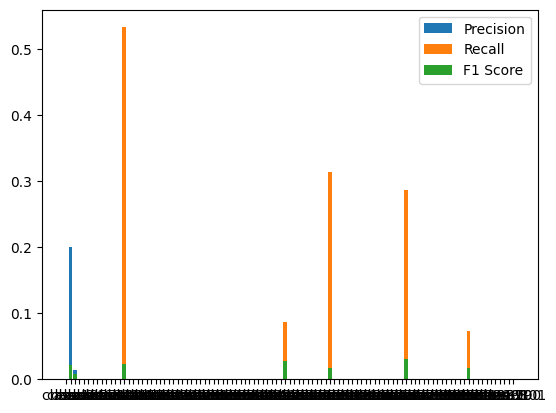

,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9,class 10,...,class 92,class 93,class 94,class 95,class 96,class 97,class 98,class 99,class 100,class 101
class 1,0,2,6,0,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 2,0,4,5,0,8,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
class 3,0,1,1,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 4,0,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
class 97,0,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 98,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 99,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 100,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
%matplotlib inline
def predictt(model, dataloader):
    y_pred = []  
    y_true = [] 
    confidence = []  

    size = len(dataloader.dataset) 

    with torch.no_grad(): 
        model.eval()  
        for batch, (X, y) in enumerate(dataloader): 

            pred = model(X)  
            pred = torch.softmax(pred, dim=1)

            y_true.extend(y.cpu().numpy())  
            y_pred_t = pred.argmax(1).cpu().numpy() 

            y_pred.extend(y_pred_t) 
            max_v, _ = pred.max(1) 
            confidence.extend(max_v.cpu().numpy())  

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    confidence = np.array(confidence)

    return y_pred, y_true, confidence 


%matplotlib inline

y_pred, y_real, _ = predictt(cnn_model, train_data_loader)
y_pred = np.array(y_pred)
y_real = np.array(y_real)


target_names = [f'class {i+1}' for i in range(101)]
report = classification_report(y_real, y_pred, target_names=target_names, output_dict=True)

print("Results of Train data")
print(classification_report(y_real, y_pred, target_names=target_names))

precision = [report[class_name]['precision'] for class_name in target_names]
recall = [report[class_name]['recall'] for class_name in target_names]
f1_score = [report[class_name]['f1-score'] for class_name in target_names]

fig, ax = plt.subplots()
ax.bar(target_names, precision, label='Precision')
ax.bar(target_names, recall, label='Recall')
ax.bar(target_names, f1_score, label='F1 Score')
ax.legend()
plt.show()

train_cm = confusion_matrix(y_real, y_pred)
pd.DataFrame(train_cm, index=target_names, columns=target_names)

c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Results of Test data
              precision    recall  f1-score   support

     class 1       0.00      0.00      0.00        92
     class 2       0.00      0.00      0.00        83
     class 3       0.00      0.00      0.00        40
     class 4       0.00      0.00      0.00       168
     class 5       0.00      0.00      0.00        12
     class 6       0.00      0.00      0.00       171
     class 7       0.00      0.00      0.00         2
     class 8       0.00      0.00      0.00         9
     class 9       0.00      0.00      0.00         4
    class 10       0.00      0.00      0.00         8
    class 11       0.00      0.00      0.00         6
    class 12       0.00      0.00      0.00         9
    class 13       0.00      0.00      0.00        24
    class 14       0.01      0.33      0.02        21
    class 15       0.00      0.00      0.00         9
    class 16       0.00      0.00      0.00        17
    class 17       0.00      0.00      0.00        21
    cl

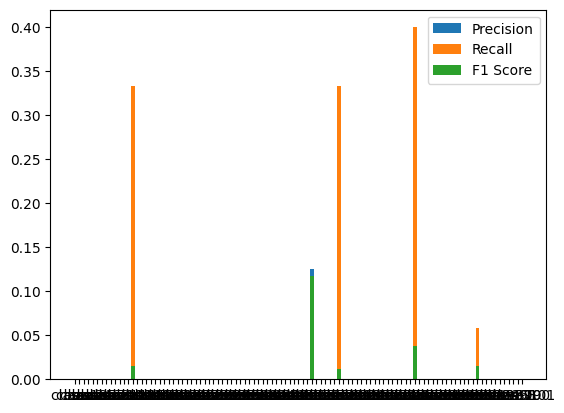

,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9,class 10,...,class 92,class 93,class 94,class 95,class 96,class 97,class 98,class 99,class 100,class 101
class 1,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 2,0,0,1,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
class 97,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 99,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
class 100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
data_categories = [f'class {i+1}' for i in range(101)]

y_pred, y_real, _ = predict(cnn_model, test_data_loader)
y_pred = np.array(y_pred)
y_real = np.array(y_real)

report = classification_report(y_real, y_pred, target_names=data_categories, output_dict=True)

print("Results of Test data")
print(classification_report(y_real, y_pred, target_names=data_categories))

precision = [report[class_name]['precision'] for class_name in data_categories]
recall = [report[class_name]['recall'] for class_name in data_categories]
f1_score = [report[class_name]['f1-score'] for class_name in data_categories]

fig, ax = plt.subplots()
ax.bar(data_categories, precision, label='Precision')
ax.bar(data_categories, recall, label='Recall')
ax.bar(data_categories, f1_score, label='F1 Score')
ax.legend()
plt.show()

test_cm = confusion_matrix(y_real, y_pred)
pd.DataFrame(test_cm, index=data_categories, columns=data_categories)

c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: Undefined

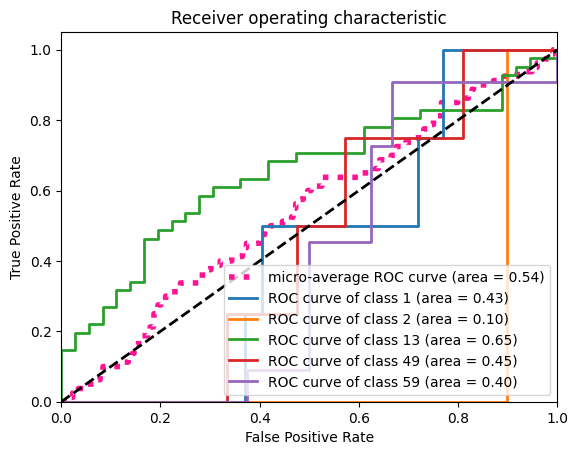

In [57]:
def roc(pred_y, true_y, confidence):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    true_prediction = pred_y == true_y

    for i in range(101):
        class_indices = np.nonzero(true_y == i)[0]

        if len(class_indices) == 0:
            continue

        fpr[i], tpr[i], _ = roc_curve(true_prediction[class_indices], confidence[class_indices])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(true_prediction, confidence)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    lw = 2
    counter = 0
    i = 0 
    while counter < 5:
        if not np.isnan(roc_auc[i]):
            plt.plot(
                fpr[i],
                tpr[i],
                lw=lw,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            )
            counter += 1
        else:
            pass
        i += 1

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

data_categories = [f'class {i+1}' for i in range(101)]

y_pred, y_real, confidence = predict(cnn_model, train_data_loader)
y_pred = np.array(y_pred)
y_real = np.array(y_real)
confidence = np.array(confidence)

roc(y_pred, y_real, confidence)


c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ghotu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true

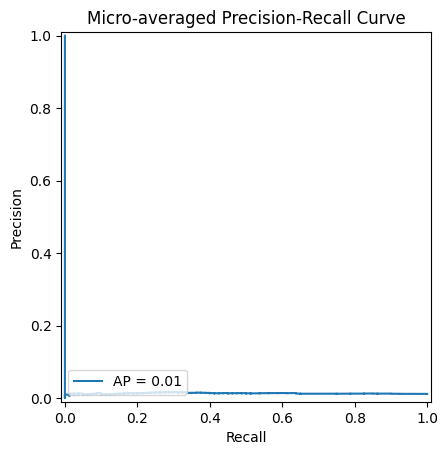

In [58]:
def auc_prc(pred_y, true_y, confidence):
    precision = dict() 
    recall = dict() 
    average_precision = dict()  
    true_prediction = pred_y == true_y

    for i in range(101):
        class_indices = np.nonzero(true_y == i)[0]
        if len(class_indices) == 0:
            continue

        precision[i], recall[i], _ = precision_recall_curve(true_prediction[class_indices], confidence[class_indices])
        average_precision[i] = average_precision_score(true_prediction[class_indices], confidence[class_indices])

    precision["micro"], recall["micro"], _ = precision_recall_curve(true_prediction, confidence)
    average_precision["micro"] = average_precision_score(true_prediction, confidence, average="micro")

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot()
    _ = display.ax_.set_title("Micro-averaged Precision-Recall Curve")

y_pred, y_real, confidence = predict(cnn_model, train_data_loader)
y_pred = np.array(y_pred)
y_real = np.array(y_real)
confidence = np.array(confidence)

auc_prc(y_pred, y_real, confidence)

In [72]:
import matplotlib.pyplot as plt
import cv2

def plot_filters_feature_maps(weights, img, cols, rows):
    fig = plt.figure(figsize=(30, 10))

    for i in range(0, cols * rows):
        ax = fig.add_subplot(rows, cols, i + 1)
        if i % 2 == 0:
            ax.imshow(weights[int(i / 2)][0])
        else:
            c = cv2.filter2D(img, -1, weights[int((i - 1) / 2)][0])
            ax.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
    
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


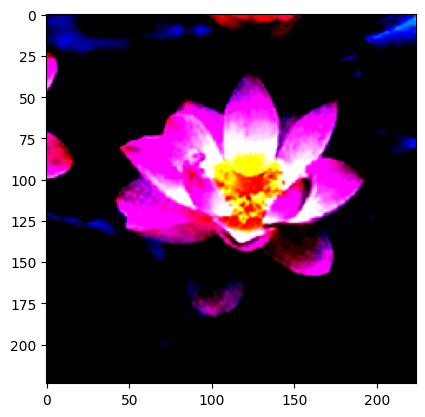

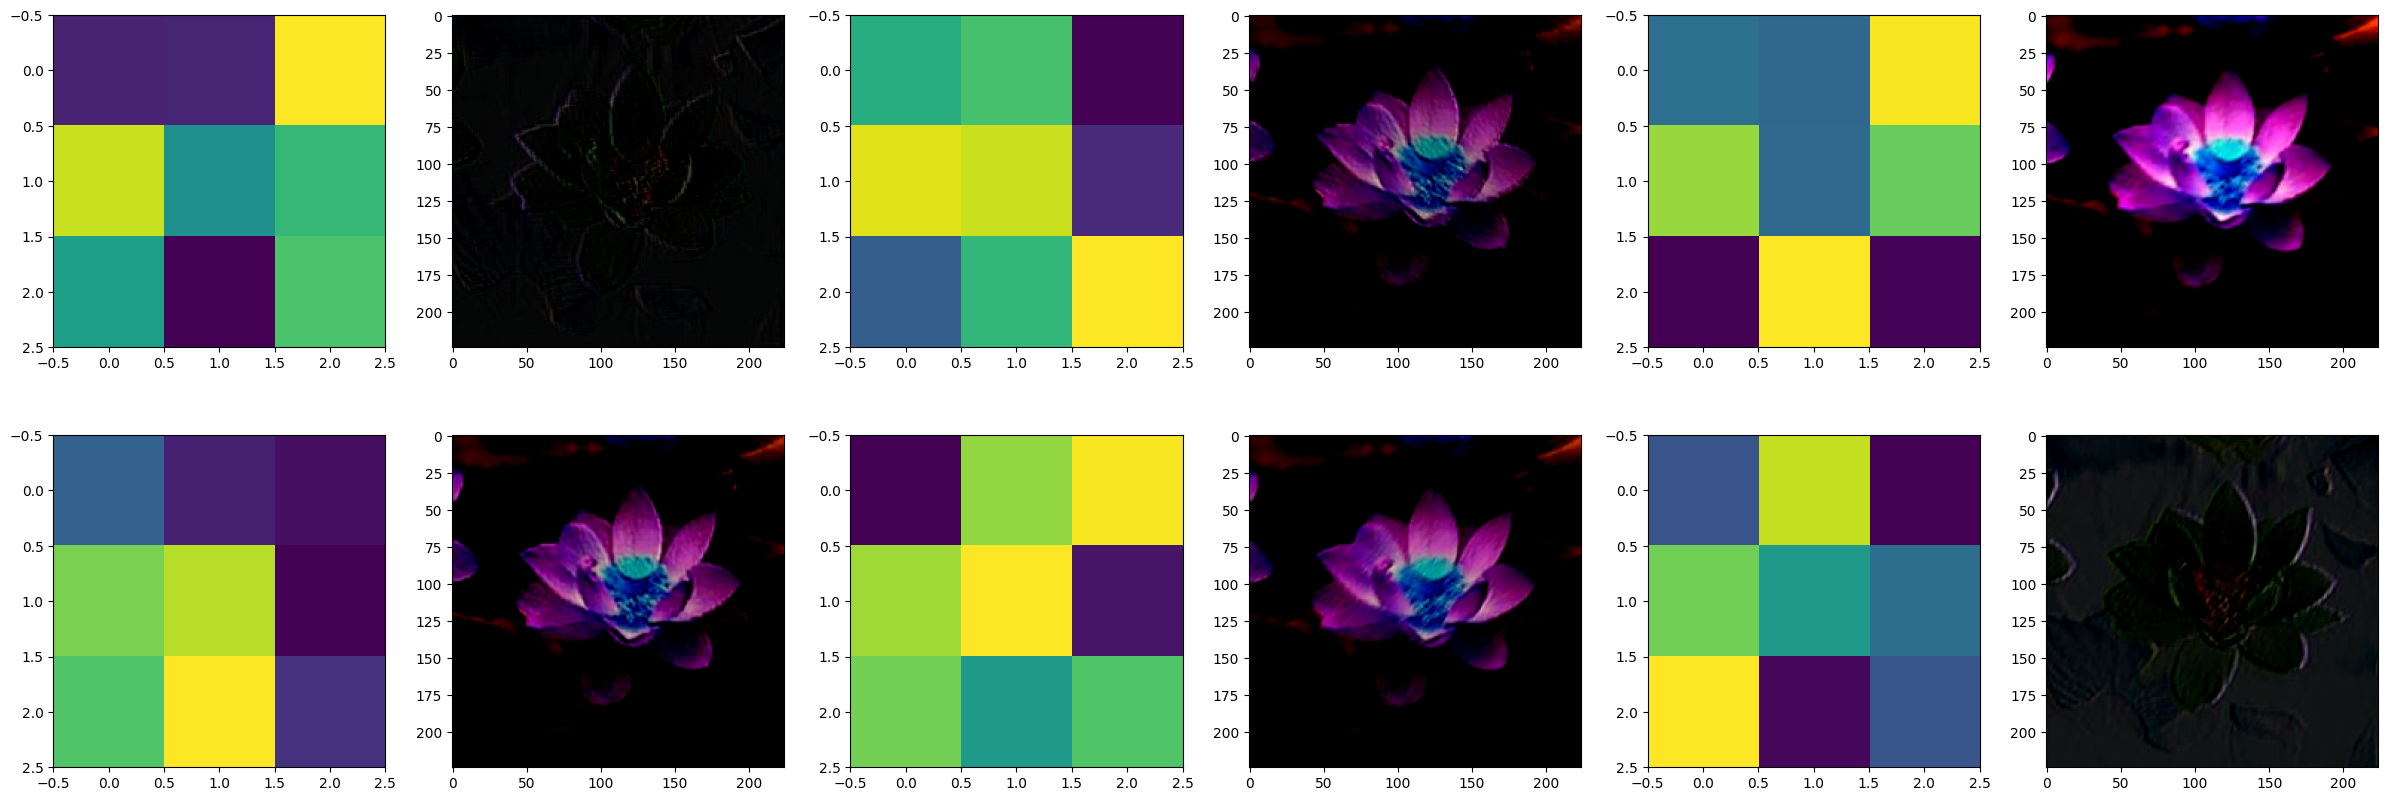

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

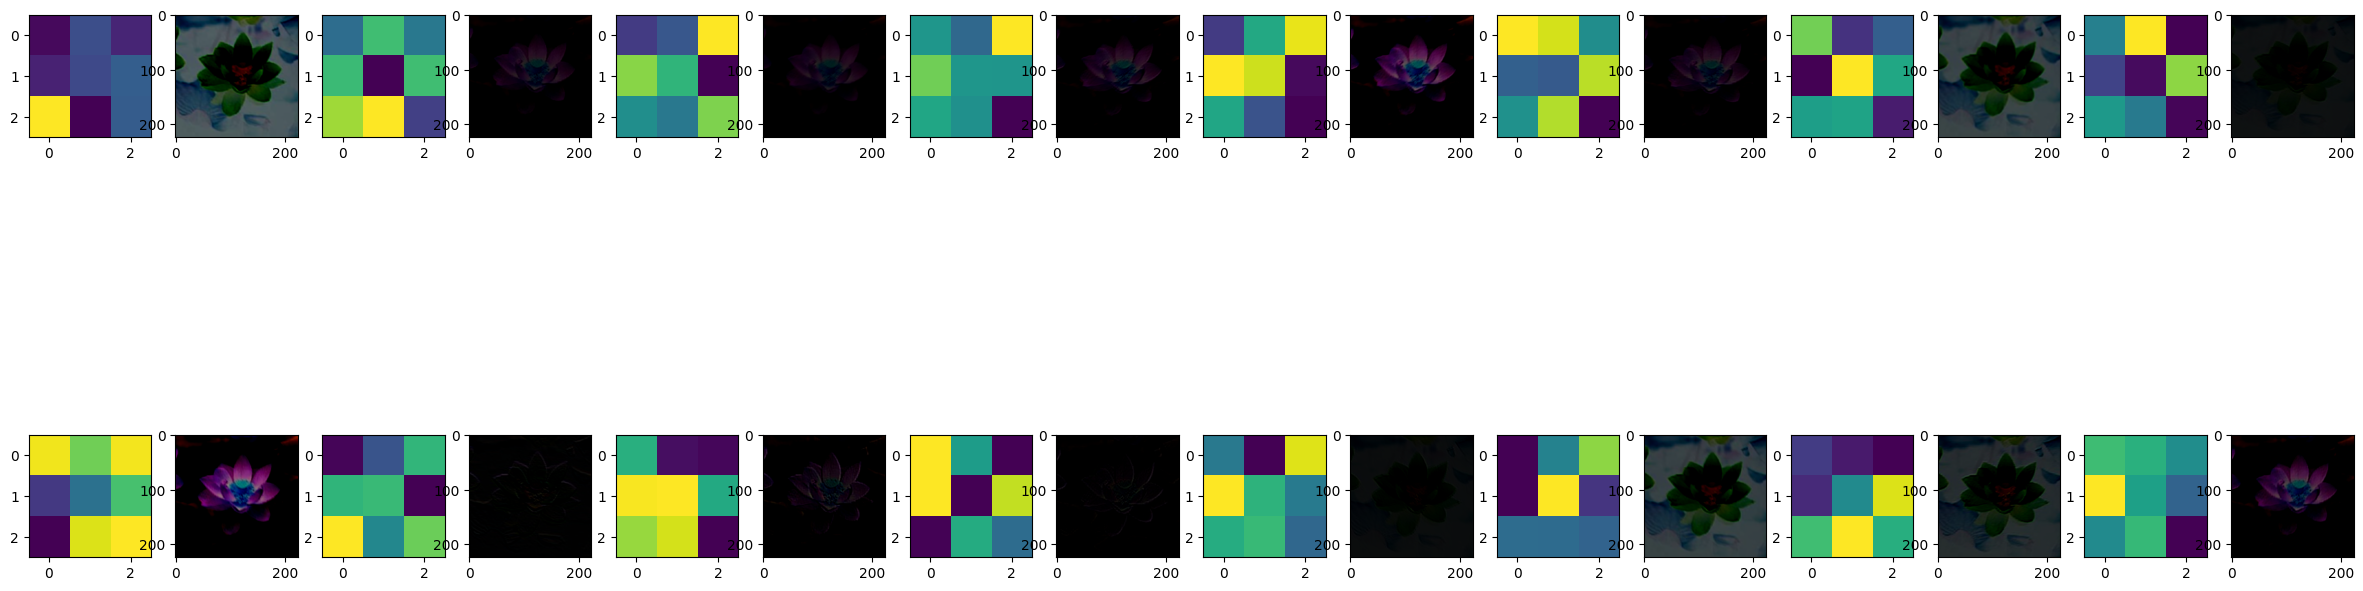

In [73]:
cnn_model.eval()

images, labels = next(iter(test_data_loader))
images = images.numpy()

idx = 6
img = np.squeeze(images[idx])
img = np.moveaxis(img, 0, -1)

plt.imshow(np.asarray(img))


weights1 = cnn_model.conv1.weight.data.numpy()

plot_filters_feature_maps(weights1, img, 6, 2)

weights2 = cnn_model.conv2.weight.data.numpy()

plot_filters_feature_maps(weights2, img, 16, 2)


The filters in the CNN model uncovered intricate patterns and distinctive characteristics within the images. These encompassed a wide range of details, including intricate structures, nuanced textures, and subtle shapes, all tailored specifically for the Caltech101 dataset's diverse object categories.

No, we don't observe filters that remained "blind" or unresponsive during the learning process. However, if such instances were present, potential strategies to address them could involve employing sophisticated initialization techniques like He or Xavier initialization, incorporating batch normalization to enhance stability and mitigate gradient issues, expanding the dataset or applying data augmentation methods, and experimenting with different network configurations regarding filter counts, layer depths, and activation functions.

The current CNN model doesn't distinctly differentiate between background elements and foreground objects in the input imagery. Instead, it learns to amalgamate features from both backgrounds and objects, potentially encompassing some extraneous background details. Nonetheless, given the dataset's thematic focus on object recognition, the model naturally prioritizes learning features relevant to the dataset's object categories.

While the model does indeed take into account the color information present in the input images, its emphasis primarily lies on discerning structural and spatial characteristics rather than color attributes. This is bolstered by the pre-training data normalization step, which effectively mitigates the influence of color variations, ensuring the model's focus remains on object shape and form.